## Implementación de una CNN con Pytorch

In [1]:
import torch
# Modulo para computer vision
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
# Carpeta root del dataset
image_path = 'dataset'
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root= image_path, train= True,
transform= transform, download= True)
mnist_valid_dataset = Subset(mnist_dataset,
torch.arange(1000))
mnist_train_dataset = Subset(mnist_dataset,
torch.arange(1000, 11000))
#torch.arange(1000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root= image_path, train= False,
transform= transform, download=False)

100%|██████████| 9912422/9912422 [00:02<00:00, 3355271.38it/s]


Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 27512081.27it/s]

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2860160.68it/s]


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw



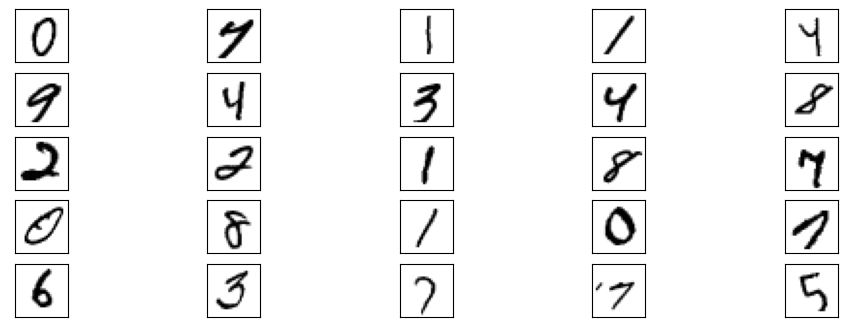

In [2]:
fig = plt.figure(figsize=(12, 4))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_train_dataset[i][0][0, :, :]
    ax.imshow(img, cmap= 'gray_r')
plt.show()

In [23]:
torch.manual_seed(1)
batch_size = 64
train_dl = DataLoader(mnist_train_dataset, batch_size= batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size= batch_size, shuffle=False)

TypeError: 'DataLoader' object is not subscriptable

- Modelo

In [4]:
model = nn.Sequential()
# Conv -> ReLU -> MaxPooling
model.add_module('conv1', nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
# Conv -> ReLU -> MaxPooling
model.add_module('conv2', nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
# Flatten
model.add_module('flatten', nn.Flatten())
# Full Connected -> ReLU -> Dropout
model.add_module('fc1', nn.Linear(3136,1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p= .5))
# Full Connected
model.add_module('fc2', nn.Linear(1024, 10))
#model.add_module('soft', nn.functional.softmax(dim=1))

In [5]:
# Selección de la unidad de procesamiento
processing_unit = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(processing_unit)
model.to(device)
print(f"You're using: {device} as device.")

You're using: cpu as device.


In [16]:
from torchinfo import summary
summary(model,input_data= torch.randint(0, 255, (batch_size, 1, 28, 28))/ 255,
col_names=["output_size", "num_params"], verbose= 0,device= device)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          832
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-3                         [64, 32, 14, 14]          --
├─Conv2d: 1-4                            [64, 64, 14, 14]          51,264
├─ReLU: 1-5                              [64, 64, 14, 14]          --
├─MaxPool2d: 1-6                         [64, 64, 7, 7]            --
├─Flatten: 1-7                           [64, 3136]                --
├─Linear: 1-8                            [64, 1024]                3,212,288
├─ReLU: 1-9                              [64, 1024]                --
├─Dropout: 1-10                          [64, 1024]                --
├─Linear: 1-11                           [64, 10]                  10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable par

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= .001)

In [20]:
def train(model, num_epochs, train_dl, valid_dl, device):
    loss_hist_train = torch.zeros(num_epochs).to(device)
    accuracy_hist_train = torch.zeros(num_epochs).to(device)
    loss_hist_valid = torch.zeros(num_epochs).to(device)
    accuracy_hist_valid = torch.zeros(num_epochs).to(device)
    for epoch in range(num_epochs):
        model.train()
        i=0
        for x_batch, y_batch in train_dl:
            i+=1
            print(i)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)
            #print(y_batch)
            #print(pred)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} '
        f'val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train.cpu(), loss_hist_valid.cpu(), accuracy_hist_train.cpu(), accuracy_hist_valid.cpu()

In [21]:
torch.manual_seed(1)
num_epochs = 1
hist = train(model, num_epochs, train_dl, valid_dl, device)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
Epoch 1 accuracy: 0.9962 val_accuracy: 0.9650


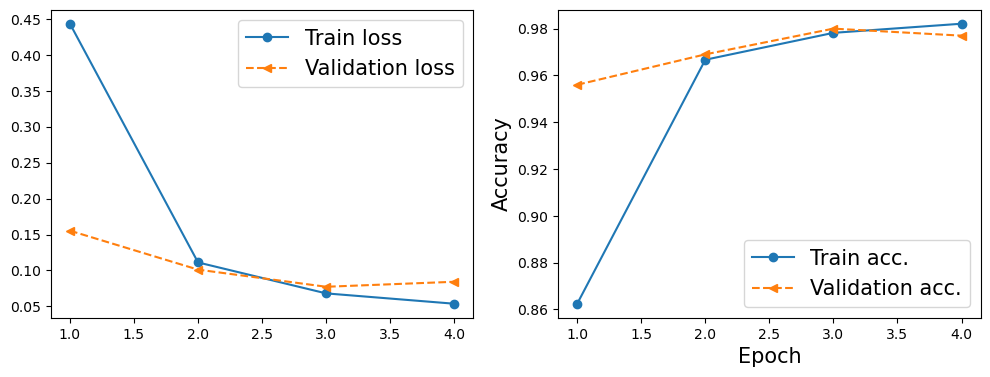

In [ ]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize= (12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
pred = model((mnist_test_dataset.data.unsqueeze(1) / 255).to(device))
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets.to(device)).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9811


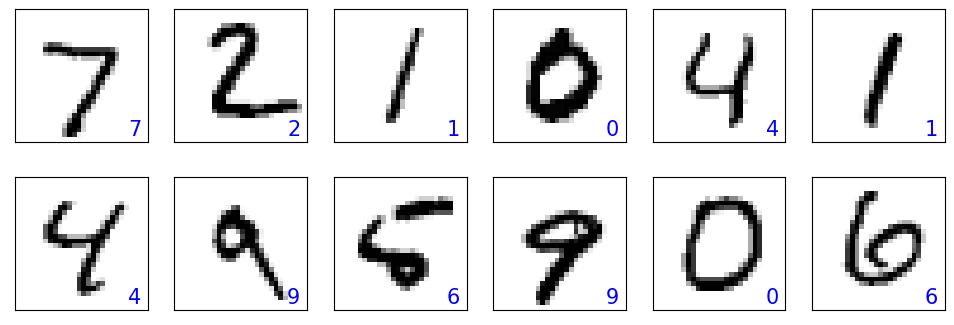

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1).to(device))
    y_pred = torch.argmax(pred.cpu())
    ax.imshow(img, cmap= 'gray_r')
    ax.text(.9, .1, y_pred.item(), size= 15, color= 'blue',
    horizontalalignment= 'center', verticalalignment= 'center',
    transform= ax.transAxes)
plt.show()